# Данные

In [2]:
!wget https://www.dropbox.com/s/nd7v1fod89xla6j/vk_texts_with_sources.csv

--2019-06-10 05:00:01--  https://www.dropbox.com/s/nd7v1fod89xla6j/vk_texts_with_sources.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/nd7v1fod89xla6j/vk_texts_with_sources.csv [following]
--2019-06-10 05:00:01--  https://www.dropbox.com/s/raw/nd7v1fod89xla6j/vk_texts_with_sources.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7be400eaef36679313fcea9bf3.dl.dropboxusercontent.com/cd/0/inline/AijbWpIq5t9MOEr0xXPiaRzB9LTHgqh034tXGu8TSthVp5sH4TlM9iM-_lg0JoWuJ8uVyFLL7sAYgwwNhWQUvGvGURukrznF-kOx7dLm13qfRw/file# [following]
--2019-06-10 05:00:01--  https://uc7be400eaef36679313fcea9bf3.dl.dropboxusercontent.com/cd/0/inline/AijbWpIq5t9MOEr0xXPiaRzB9LTHgqh034tXGu8TSthVp5sH4TlM9iM-_lg0JoWuJ8uVyFLL7sAYgwwNhWQUvGvGURukrznF

In [1]:
import pandas as pd
df = pd.read_csv('vk_texts_with_sources.csv', usecols = ['text', 'source'])
df.head()

,text,source
0,Начальник Главного оперативного управления Ген...,mil
1,Артиллерийские подразделения общевойскового об...,mil
2,Подразделения морской пехоты Каспийской флотил...,mil
3,Команды на всеармейских этапах конкурсов АрМИ-...,mil
4,На большом учебно-методическом командирском сб...,mil


# Задача

Решение задачи тематической классификации. Даны тексты, опубликованные в нескольких пабликах VK.com, посвященных государственным и муниципальным службам. Формально задача заключается в том, чтобы по тексту ($d$) определить в каком паблике он опубликован, то есть, к какому классу $c$ он принадлежит. 

## Описательные статистики

Необходимо подсчитать:
* количество текстов и количество классов
* количество слов (без лемматизации и с лемматизацией) в коллекции
* среднюю длину текста в словах и символах
* найти 5 самых частых существительных в текстах каждого паблика 

### Подключение библиотек

In [2]:
import re
import nltk
from pymorphy2 import MorphAnalyzer
import numpy as np
import collections
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

###  Предобработка данных

Если посмотреть на текст, можно заметить, что некоторые html-тэги стоят вплотную к словам и, следовательно, будут мешать правильному подсчету слов и решению дальнейших задач. Также в текстах встречаются ссылки и хэштэги. Перед началом выполнения задач я предобработаю текст, удалив html-тэги и ссылки. Хэштэги оставлю, они могут улучшить качество классификации. Также необходимо удалить строки, содержащие пустые значения. 

In [3]:
#Просмотр части данных
df['text'][6]

'Военнослужащие–женщины на бронеавтомобилях продемонстрируют автошоу на открытии всеармейского этапа конкурса АрМИ «Мастера автобронетанковой техники-2018», который состоится 26 и 27 мая в городе Острогожске в Воронежской области <br><br>В этом году в конкурсе принимают участие 13 команд военных автомобилистов и специалистов автобронетанковой службы военных округов и флотов, РВСН, ВДВ и ВВС, а также Центра контраварийной подготовки ВС РФ, Острогожского учебного центра по подготовке младших специалистов автобронетанковой службы и 147-й автомобильной базы Минобороны России. <br><br>В преддверии Дня военного автомобилиста для гостей и жителей города приготовлена программа выступления водителей бронеавтомобилей «Тигр», КамАЗ-5350 и УАЗ–3151. <br><br>Ссылка на сайт Армейских международных игр-2018: http://armygames2018.mil.ru/ <br><br>#Минобороны #АрМИ2018 #МастераАвтобронетанковойТехники'

In [4]:
#Удаление строк, содержащих пустые значения 
df = df.dropna()

In [5]:
length = df.shape[0]

for i in range(length):
    df.iloc[i, 0] = re.sub('<.*?>', '', df.iloc[i, 0])

for i in range(length):
    df.iloc[i, 0] = re.sub('http?:\/\/.*[\r\n]*\/', '', df.iloc[i, 0])

In [6]:
df['text'][6]

'Военнослужащие–женщины на бронеавтомобилях продемонстрируют автошоу на открытии всеармейского этапа конкурса АрМИ «Мастера автобронетанковой техники-2018», который состоится 26 и 27 мая в городе Острогожске в Воронежской области В этом году в конкурсе принимают участие 13 команд военных автомобилистов и специалистов автобронетанковой службы военных округов и флотов, РВСН, ВДВ и ВВС, а также Центра контраварийной подготовки ВС РФ, Острогожского учебного центра по подготовке младших специалистов автобронетанковой службы и 147-й автомобильной базы Минобороны России. В преддверии Дня военного автомобилиста для гостей и жителей города приготовлена программа выступления водителей бронеавтомобилей «Тигр», КамАЗ-5350 и УАЗ–3151. Ссылка на сайт Армейских международных игр-2018:  #Минобороны #АрМИ2018 #МастераАвтобронетанковойТехники'

### Подсчет количества текстов и классов

In [0]:
print('Количество текстов в коллекции - ', df.shape[0])
print('Количество классов в коллекции - ', len(set(df.source.tolist())))

Количество текстов в коллекции -  11526
Количество классов в коллекции -  4


### Подсчет количества слов в коллекции

#### Без лемматизации

In [0]:
number_of_words = set()
for i in df.text.tolist():
    number_of_words.update(nltk.word_tokenize(str(i)))
        
print('Количество уникальных слов в коллекции до лемматизации - ', len(number_of_words))

Количество уникальных слов в коллекции до лемматизации -  98410


#### С лемматизацией

In [0]:
morph = MorphAnalyzer()
number_of_words2 = set()

for i in df.text.tolist():
    temp = list()
    for j in nltk.word_tokenize(str(i)):
        temp.append(str(morph.parse(j)[0].normal_form))
    number_of_words2.update(temp)

print('Количество уникальных слов в коллекции после лемматизации - ', len(number_of_words2))

Количество уникальных слов в коллекции после лемматизации -  44938


### Подсчет средней длины текста в словах и символах

In [0]:
mean_length_of_text_in_words = list()
mean_length_of_text_in_chars = list()

for i in df.text.tolist():    
    mean_length_of_text_in_words.append(len(nltk.word_tokenize(str(i))))
    mean_length_of_text_in_chars.append(len(str(i)))
    
print('Средняя длина текста в словах - ', np.mean(mean_length_of_text_in_words))
print('Средняя длина текста в символах - ', np.mean(mean_length_of_text_in_chars))

Средняя длина текста в словах -  100.49340621204234
Средняя длина текста в символах -  658.346347388513


### Поиск 5 самых частых существительных в текстах каждого паблика

In [0]:
list_of_words = list()
list_of_classes = list(set(df.source.tolist()))


for i in list_of_classes:
    temp = df[df['source'] == i]
    temp_list_of_words = list()
    for j in temp.text.tolist():
        for k in nltk.word_tokenize(str(j)):
            if 'NOUN' in str(morph.parse(k)[0].tag):
                temp_list_of_words.append(str(k))
    list_of_words.append(temp_list_of_words)
    


for i in range(len(list_of_classes)):
    print('Самый частые существительные в классе', list_of_classes[i])
    print(collections.Counter(list_of_words[i]).most_common(5))

Самый частые существительные в классе mospolice
[('МВД', 4944), ('России', 3887), ('полиции', 2977), ('Москве', 2672), ('полиция', 2616)]
Самый частые существительные в классе mchsgov
[('МЧС', 3481), ('России', 1647), ('МЧСРОССИИ', 1226), ('безопасности', 347), ('области', 271)]
Самый частые существительные в классе russianpost
[('России', 2527), ('Почты', 1123), ('ПочтаРоссии', 936), ('Почта', 825), ('года', 678)]
Самый частые существительные в классе mil
[('Минобороны', 1811), ('России', 1178), ('обороны', 798), ('военного', 735), ('ходе', 697)]


### Разделение коллекции текстов на обучающую и тестовую выборку

Т.к. классы представляют из себя названия сообществ, перед разделением необходимо закодировать их целыми числами

In [7]:
encoding = preprocessing.LabelEncoder()
encoding.fit(list(set(df.source.tolist())))

df['source'] = encoding.transform(df.source.tolist())
df.head()

,text,source
0,Начальник Главного оперативного управления Ген...,1
1,Артиллерийские подразделения общевойскового об...,1
2,Подразделения морской пехоты Каспийской флотил...,1
3,Команды на всеармейских этапах конкурсов АрМИ-...,1
4,На большом учебно-методическом командирском сб...,1


In [0]:
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['source'], test_size=0.2, random_state=12)

 ## Классификация по правилам
 
 * Разработаю несколько правил вида "Если встречается слово $w$, то текст относится к паблику $c$"
 * Посчитаю, какую точность, полноту, $f$-меру и $accuracy$ получаю при классификации по правилам
 * Проверю, получилось ли придумать правило, которое никогда не ошибается

### Подключение библиотек

In [8]:
import random
from sklearn.metrics import accuracy_score, classification_report

### Просмотр меток классов

In [0]:
for i in range(len(encoding.classes_)):
    print(encoding.classes_[i], i)

mchsgov 0
mil 1
mospolice 2
russianpost 3


### Создание правила

In [0]:
rules = list()
length_x_test = x_test.shape[0]
for i in range(length_x_test):
    if 'МЧС' in x_test.iloc[i] or 'МЧСРОССИИ' in x_test.iloc[i] or 'БудниМЧС' in x_test.iloc[i]:
        rules.append(0)
    elif 'Минобороны' in x_test.iloc[i] or 'обороны' in x_test.iloc[i] or 'военного' in x_test.iloc[i]:
        rules.append(1)
    elif 'МВД' in x_test.iloc[i] or 'полиции' in x_test.iloc[i] or 'полиция' in x_test.iloc[i]:
        rules.append(2)
    elif 'Почты' in x_test.iloc[i] or 'Почта' in x_test.iloc[i] or 'года' in x_test.iloc[i]:
        rules.append(3)
    else:
        rules.append(random.randint(0, 3))

### Подсчет точности, полноты и f-меры

In [0]:
print(classification_report(y_test, rules))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       590
           1       0.85      0.74      0.79       600
           2       0.84      0.97      0.90       569
           3       0.79      0.72      0.75       547

   micro avg       0.83      0.83      0.83      2306
   macro avg       0.83      0.83      0.83      2306
weighted avg       0.83      0.83      0.83      2306



### Подсчет accuracy

In [0]:
print('Accuracy - ', accuracy_score(y_test, rules[0:]))

Accuracy -  0.8317432784041631


### Результат

У меня не получилось придумать правило, которое бы не ошибалось. Но метрики получились неплохие, что показывает, что по самым частовстречающимся словам можно предсказывать метку для текста

## Baseline
Использую стандартный ```sklearn.pipeline``` для классификации текстов: 
* векторизация 
* $tf-idf$ взвешивание 
* логистическую регрессию

Оценю результаты классификации по стандартным мерам качества и проведу анализ ошибок. Для этого визуализирую матрицу ошибок (confusion matrix). 

In [9]:
import seaborn as sn
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

### Обучение pipline

In [0]:
baseline = Pipeline([
    ('vectorization', CountVectorizer()),
    ('tf-idf', TfidfTransformer()),
    ('LR', LogisticRegression())
])

In [0]:
baseline.fit(x_train, y_train)

/usr/local/lib64/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib64/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('vectorization', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
    ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [0]:
baseline_predicted = baseline.predict(x_test)

### Результаты классификации

In [0]:
print(classification_report(y_test, baseline_predicted))
print('Accuracy - ', accuracy_score(y_test, baseline_predicted))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       590
           1       0.97      0.98      0.98       600
           2       0.97      0.98      0.98       569
           3       0.95      0.96      0.95       547

   micro avg       0.97      0.97      0.97      2306
   macro avg       0.97      0.97      0.97      2306
weighted avg       0.97      0.97      0.97      2306

Accuracy -  0.9679098005203816


### Матрица ошибок

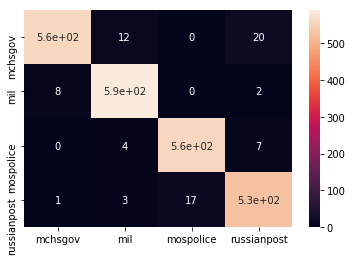

In [0]:
conf_matrix = confusion_matrix(y_test, baseline_predicted)
df_conf_matrix = pd.DataFrame(conf_matrix, index = [i for i in encoding.classes_], columns = [i for i in encoding.classes_])
sn.heatmap(df_conf_matrix, annot=True)

### Результат

Данный метод лучше решает задачу. По матрице ошибок видно, что чаще всего он ошибается на классах МЧС и Почта России и на классах Почта России и МВД. 

## Снижение размерности
Добавлю в ```sklearn.pipeline```  методы снижения размерности TruncatedSVD.

In [0]:
from sklearn.decomposition import TruncatedSVD

In [0]:
baseline = Pipeline([
    ('vectorization', CountVectorizer()),
    ('tf-idf', TfidfTransformer()),
    ('svd', TruncatedSVD(n_components=500)),
    ('LR', LogisticRegression())
])

In [0]:
baseline.fit(x_train, y_train)

/usr/local/lib64/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('vectorization', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
    ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [0]:
baseline_predicted = baseline.predict(x_test)

### Результаты классификации

In [0]:
print(classification_report(y_test, baseline_predicted))
print('Accuracy - ', accuracy_score(y_test, baseline_predicted))

              precision    recall  f1-score   support

           0       0.98      0.93      0.96       590
           1       0.96      0.98      0.97       600
           2       0.97      0.98      0.97       569
           3       0.94      0.96      0.95       547

   micro avg       0.96      0.96      0.96      2306
   macro avg       0.96      0.96      0.96      2306
weighted avg       0.96      0.96      0.96      2306

Accuracy -  0.9622723330442324


### Матрица ошибок

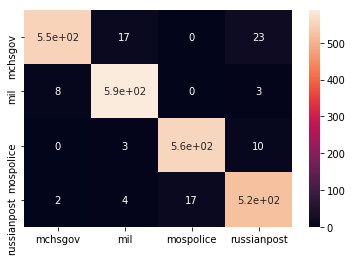

In [0]:
conf_matrix = confusion_matrix(y_test, baseline_predicted)
df_conf_matrix = pd.DataFrame(conf_matrix, index = [i for i in encoding.classes_], columns = [i for i in encoding.classes_])
sn.heatmap(df_conf_matrix, annot=True)

### Результат

При моём сочетании моделей видно, что понижение размерности не улучшило качество.

## Лемматизация

In [0]:
df_lemm = pd.DataFrame({'text': df.text.values, 'source': df.source.values})

In [0]:
morph = MorphAnalyzer()

for i in range(df_lemm.shape[0]):
    temp = ''
    for j in nltk.word_tokenize(str(df_lemm.iloc[i, 0])):
        temp += str(morph.parse(j)[0].normal_form) + ' '
    df_lemm.iloc[i, 0] = temp

In [0]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(df_lemm['text'], df_lemm['source'], test_size=0.2, random_state=12)

In [0]:
baseline = Pipeline([
    ('vectorization', CountVectorizer()),
    ('tf-idf', TfidfTransformer()),
    ('svd', TruncatedSVD(n_components=500)),
    ('LR', LogisticRegression())
])

In [0]:
baseline.fit(x_train2, y_train2)

/usr/local/lib64/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib64/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('vectorization', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
    ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [0]:
baseline_predicted = baseline.predict(x_test2)

### Результаты классификации

In [0]:
print(classification_report(y_test2, baseline_predicted))
print('Accuracy - ', accuracy_score(y_test2, baseline_predicted))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       590
           1       0.98      0.98      0.98       600
           2       0.97      0.99      0.98       569
           3       0.97      0.96      0.96       547

   micro avg       0.97      0.97      0.97      2306
   macro avg       0.97      0.97      0.97      2306
weighted avg       0.97      0.97      0.97      2306

Accuracy -  0.9731136166522116


### Матрица ошибок

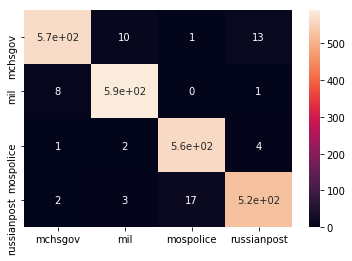

In [0]:
conf_matrix = confusion_matrix(y_test2, baseline_predicted)
df_conf_matrix = pd.DataFrame(conf_matrix, index = [i for i in encoding.classes_], columns = [i for i in encoding.classes_])
sn.heatmap(df_conf_matrix, annot=True)

### Результат

Accuracy стало больше 97%. Уменьшились ошибки для классов МЧС и Почта России и для классов Почта России и МВД. 

## Continious bag of words
Для baseline решения я использовала обычное представление текста в виде мешка слов. Попробую использовать другие модели представления текста – например, в виде непрерывного мешка слов, то есть, в виде набора эмбеддингов. Для того, чтобы получить вектор текста обучу Word2vec.

In [0]:
from gensim.models import word2vec, KeyedVectors

### Обучение модели Word2Vec

In [0]:
def build_corpus(data):
    corpus = []
    for sentence in data:
        word_list = sentence.split(" ")
        corpus.append(word_list)
    return corpus

In [0]:
corpus = build_corpus(df['text'])

In [0]:
model = word2vec.Word2Vec(corpus, size=50, window=3, min_count=1, workers=4)

In [0]:
#создание словаря со словами и соответствующими векторами 
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


In [0]:
#функция для создания векторов текстов
def vector_for_sentence(w2v_dict, data):
    return np.array([
        np.mean([w2v_dict[w] for w in sentence if w in w2v_dict]
        or [np.zeros(50)], axis=0)
         for sentence in data
    ])

In [0]:
data_vectors = vector_for_sentence(w2v, corpus)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(data_vectors, df['source'], test_size=0.2, random_state=12)

In [0]:
classifier = Pipeline([
    ('LR', LogisticRegression())
])

In [0]:
classifier.fit(x_train, y_train)

/usr/local/lib64/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib64/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('LR', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [0]:
classifier_predicted = classifier.predict(x_test)

### Результаты классификации

In [0]:
print(classification_report(y_test, classifier_predicted))
print('Accuracy - ', accuracy_score(y_test, classifier_predicted))

              precision    recall  f1-score   support

           0       0.84      0.74      0.79       590
           1       0.85      0.87      0.86       600
           2       0.92      0.89      0.90       569
           3       0.73      0.84      0.78       547

   micro avg       0.83      0.83      0.83      2306
   macro avg       0.84      0.83      0.83      2306
weighted avg       0.84      0.83      0.83      2306

Accuracy -  0.8330442324371206


### Матрица ошибок

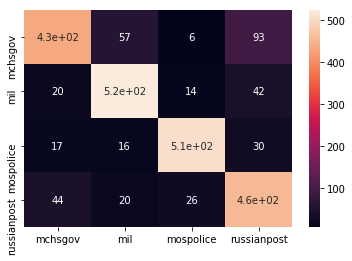

In [0]:
conf_matrix = confusion_matrix(y_test, classifier_predicted)
df_conf_matrix = pd.DataFrame(conf_matrix, index = [i for i in encoding.classes_], columns = [i for i in encoding.classes_])
sn.heatmap(df_conf_matrix, annot=True)

### Результат

Качество на данных сильно упало по сравнению с предыдущими методами, хотя я и обучала сама вектора, а не использовала предобученные. Также, данная модель стала выдавать больше ошибок

## fastText

Использую ```fastText``` в режиме классификации. 

### Подготовка данных для использования fastText

In [20]:
df_fasttext = pd.DataFrame({'text': df.text.values, 'source': list(map(lambda i: '__label__' + str(i), df.source.values))})

In [21]:
df_fasttext.head()

,text,source
0,Начальник Главного оперативного управления Ген...,__label__1
1,Артиллерийские подразделения общевойскового об...,__label__1
2,Подразделения морской пехоты Каспийской флотил...,__label__1
3,Команды на всеармейских этапах конкурсов АрМИ-...,__label__1
4,На большом учебно-методическом командирском сб...,__label__1


In [22]:
x_train, x_test, y_train, y_test = train_test_split(df_fasttext['text'], df_fasttext['source'], test_size=0.2, random_state=12)

In [23]:
#Для использования fasttext необходимо сохранить данные в .txt формате

with open('vk_texts_with_sources_train.txt', 'w') as fasttext_train:
    for i in range(x_train.shape[0]):
        fasttext_train.write(x_train.iloc[i] + '\t' + y_train.iloc[i] + '\n')
        
with open('vk_texts_with_sources_test.txt', 'w') as fasttext_test:
    for i in range(x_test.shape[0]):
        fasttext_test.write(x_test.iloc[i] + '\t' + y_test.iloc[i] + '\n')

### Обучение модель FastText

In [51]:
!fasttext supervised -input vk_texts_with_sources_train.txt -output fasttext_model -minn 3 -maxn 5 -wordNgrams 3 -dim 20 -epoch 10 -thread 4

Read 0M words
Number of words:  116819
Number of labels: 4
Progress: 100.0% words/sec/thread:  160837 lr: -0.000005 loss:  0.567602 ETA:   0h 0mh 0m 77.6% words/sec/thread:  156560 lr:  0.022392 loss:  0.673307 ETA:   0h 0m100.0% words/sec/thread:  160834 lr:  0.000000 loss:  0.567602 ETA:   0h 0m


In [52]:
!fasttext quantize -input vk_texts_with_sources_train.txt -output fasttext_model

In [53]:
!fasttext test fasttext_model.ftz vk_texts_with_sources_test.txt  1

N	2306
P@1	0.958
R@1	0.958


In [54]:
!fasttext predict-prob fasttext_model.ftz vk_texts_with_sources_test.txt > fasttext_predict.txt

In [55]:
with open('fasttext_predict.txt') as file:
    lines = file.readlines()
    
fasttext_predicted = list()

for i in lines:
    fasttext_predicted.append(i.split(' ')[0])

### Результаты классификации

In [56]:
print(classification_report(y_test, fasttext_predicted))
print('Accuracy - ', accuracy_score(y_test, fasttext_predicted))

              precision    recall  f1-score   support

  __label__0       0.99      0.95      0.97       590
  __label__1       0.96      0.98      0.97       600
  __label__2       0.96      0.95      0.96       569
  __label__3       0.92      0.95      0.94       547

   micro avg       0.96      0.96      0.96      2306
   macro avg       0.96      0.96      0.96      2306
weighted avg       0.96      0.96      0.96      2306

Accuracy -  0.95836947094536


### Матрица ошибок

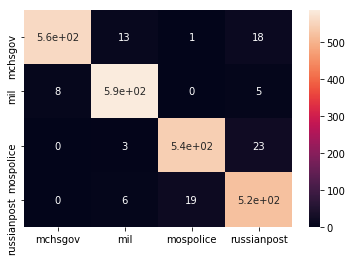

In [57]:
conf_matrix = confusion_matrix(y_test, fasttext_predicted)
df_conf_matrix = pd.DataFrame(conf_matrix, index = [i for i in encoding.classes_], columns = [i for i in encoding.classes_])
sn.heatmap(df_conf_matrix, annot=True)

### Результат

Данный эксперимент показывает, что FastText справляется с задачей значительно лучше, чем Word2Vec. Также данная модель выдает значительно меньше ошибок.

## CNN

Реализую модель Kim et al (2014) для решения задачи классификации с помощью CNN. 

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.layers import *
from keras import Sequential,optimizers

In [0]:
df_cnn_and_rnn = pd.DataFrame({'text': df.text.values, 'source': df.source.values})

In [0]:
x_train, x_test, y_train, y_test = train_test_split(df_cnn_and_rnn['text'], df_cnn_and_rnn['source'], test_size=0.2, random_state=12)

In [0]:
tokenizer = Tokenizer(num_words=98410)
tokenizer.fit_on_texts(x_train)

sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)

x_train = sequence.pad_sequences(sequences_train,maxlen=150)
x_test = sequence.pad_sequences(sequences_test,maxlen=150)

In [0]:
vocab_size = tokenizer.word_index.__len__() + 1
embedding_dim = 50
num_filters = 32 
adam = optimizers.Adam(lr=0.001)
model = Sequential()
model.add(Embedding(vocab_size,
                    embedding_dim,
                    input_length=max_length))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu')) 
model.add(Dense(8, activation='softmax'))  
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [0]:
cnn_model = model.fit(x_train, y_train, batch_size=100, epochs=10)

Epoch 1/10
9220/9220 [==============================] - 12s 1ms/step - loss: 1.4756 - acc: 0.4352
Epoch 2/10
9220/9220 [==============================] - 11s 1ms/step - loss: 0.3456 - acc: 0.9145
Epoch 3/10
9220/9220 [==============================] - 11s 1ms/step - loss: 0.1452 - acc: 0.9664
Epoch 4/10
9220/9220 [==============================] - 11s 1ms/step - loss: 0.0878 - acc: 0.9778
Epoch 5/10
9220/9220 [==============================] - 11s 1ms/step - loss: 0.0599 - acc: 0.9844
Epoch 6/10
9220/9220 [==============================] - 11s 1ms/step - loss: 0.0437 - acc: 0.9884
Epoch 7/10
9220/9220 [==============================] - 10s 1ms/step - loss: 0.0349 - acc: 0.9914
Epoch 8/10
9220/9220 [==============================] - 11s 1ms/step - loss: 0.0289 - acc: 0.9922
Epoch 9/10
9220/9220 [==============================] - 10s 1ms/step - loss: 0.0227 - acc: 0.9937
Epoch 10/10
9220/9220 [==============================] - 10s 1ms/step - loss: 0.0152 - acc: 0.9958


In [0]:
cnn_predicted = model.predict_classes(x_test)

### Результаты классификации

In [0]:
print(classification_report(y_test, cnn_predicted))
print('Accuracy - ', accuracy_score(y_test, cnn_predicted))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       590
           1       0.99      0.97      0.98       600
           2       0.98      0.98      0.98       569
           3       0.94      0.96      0.95       547

   micro avg       0.97      0.97      0.97      2306
   macro avg       0.97      0.97      0.97      2306
weighted avg       0.97      0.97      0.97      2306

Accuracy -  0.9700780572419775


### Матрица ошибок

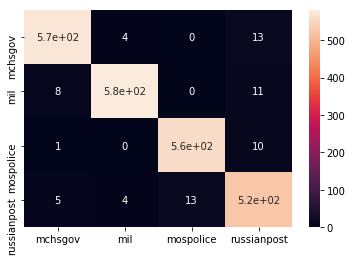

In [0]:
conf_matrix = confusion_matrix(y_test, cnn_predicted)
df_conf_matrix = pd.DataFrame(conf_matrix, index = [i for i in encoding.classes_], columns = [i for i in encoding.classes_])
sn.heatmap(df_conf_matrix, annot=True)

### Результат

Данная модель показывает хорошее значение Accuracy при быстром обучении. Также, она показывает значительно меньшее количество ошибок и на пересечении некоторых классов ошибок вообще нет.

## RNN

Использую ```RNN``` для решения задачи текстовой классификации. 

In [0]:
model = Sequential()
model.add(Embedding(vocab_size,
                    embedding_dim,
                    input_length=max_length))
model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.25, recurrent_dropout=0.1)))
model.add(GlobalMaxPooling1D())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='softmax'))  
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [0]:
rnn_model = model.fit(x_train, y_train, batch_size=100, epochs=10)

Epoch 1/10
9220/9220 [==============================] - 38s 4ms/step - loss: 0.0098 - acc: 0.9975
Epoch 2/10
9220/9220 [==============================] - 41s 4ms/step - loss: 0.0085 - acc: 0.9972
Epoch 3/10
9220/9220 [==============================] - 36s 4ms/step - loss: 0.0093 - acc: 0.9978
Epoch 4/10
9220/9220 [==============================] - 38s 4ms/step - loss: 0.0069 - acc: 0.9983
Epoch 5/10
9220/9220 [==============================] - 45s 5ms/step - loss: 0.0066 - acc: 0.9978
Epoch 6/10
9220/9220 [==============================] - 41s 4ms/step - loss: 0.0067 - acc: 0.9980
Epoch 7/10
9220/9220 [==============================] - 37s 4ms/step - loss: 0.0059 - acc: 0.9980
Epoch 8/10
9220/9220 [==============================] - 40s 4ms/step - loss: 0.0050 - acc: 0.9982
Epoch 9/10
9220/9220 [==============================] - 39s 4ms/step - loss: 0.0044 - acc: 0.9988
Epoch 10/10
9220/9220 [==============================] - 39s 4ms/step - loss: 0.0041 - acc: 0.9988


In [0]:
rnn_predicted = model.predict_classes(x_test)

### Результаты классификации

In [0]:
print(classification_report(y_test, rnn_predicted))
print('Accuracy - ', accuracy_score(y_test, rnn_predicted))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       590
           1       0.97      0.96      0.97       600
           2       0.97      0.99      0.98       569
           3       0.95      0.95      0.95       547

   micro avg       0.96      0.96      0.96      2306
   macro avg       0.96      0.96      0.96      2306
weighted avg       0.96      0.96      0.96      2306

Accuracy -  0.9648742411101474


### Матрица ошибок

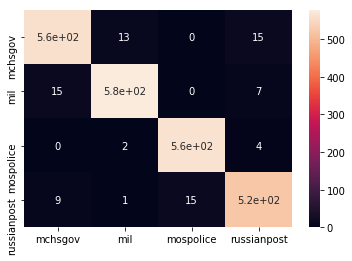

In [0]:
conf_matrix = confusion_matrix(y_test, rnn_predicted)
df_conf_matrix = pd.DataFrame(conf_matrix, index = [i for i in encoding.classes_], columns = [i for i in encoding.classes_])
sn.heatmap(df_conf_matrix, annot=True)

### Результат

Данная модель тоже показывает неплохой результат, но чуть хуже, чем CNN. И данная модель чуть чаще совершает ошибки

## ULMFit

Использую ```ULMFit``` для решения задачи классификации. 

In [0]:
import fastai
from fastai import *
from fastai.text import * 

In [0]:
ulm_train, ulm_validation = train_test_split(df, stratify = df['source'], test_size = 0.2, random_state = 12)

In [0]:
data_ulm = TextLMDataBunch.from_df(train_df=ulm_train, valid_df=ulm_validation, path='')

In [20]:
data_class = TextClasDataBunch.from_df(path = '', train_df = ulm_train, valid_df = ulm_validation, vocab=data_ulm.train_ds.vocab, bs=32)

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:525: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
Столичные полицейские выявили мошенничество с недвижимостью умерших граждан Сотрудники ОУР УВД по СВАО ГУ МВД России по г. Москве во взаимодействии с представителями Правительства Москвы выявили мошенничество с недвижимостью умерших граждан.  Полицейские установили, что трое злоумышленников по поддельным документам завладели правом на квартиру, расположенную на Алтуфьевском шоссе. Жилплощадь принадлежала умершей семейной паре, не имевшей наследников, и подлежала обращению в доход государства.  Подозреваемые реализовали недвижимость, совершив легализацию денежных средств на сумму более 6 млн рублей, причинив тем самым материальный ущерб Департаменту городского имущества г. Москвы.  В ходе оперативно-разыскных мероприятий стражи порядка задержали организатора группы

In [21]:
data_class.show_batch()

text,target
xxbos 1,"Образец перспективного основного боевого танка Т-14, создаваемый в рамках ОКР «Армата», в ходе войсковых испытаний в 1-й ударной гвардейской танковой армии#Минобороны #Танки #СухопутныеВойска #Армата"
xxbos 0,#МЧС #МЧСРОССИИ Глава МЧС России Владимир Пучков наградил победителей XIV Всероссийских соревнований «Школа безопасности».
xxbos 0,#МЧС #МЧСРОССИИ В Ставропольском крае в рамках Года культуры безопасности прошел первый в России детский флешмоб «МЧС России за безопасное поколение».
xxbos 2,"Во время праздничных мероприятий и народных гуляний, посвященных встрече Нового, 2017 года и празднованию Рождества Христова, сотрудниками ГУ МВД России по г. Москве принимаются необходимые меры для обеспечения безопасности жителей и гостей города. ТЕЛЕФОНЫ ЭКСТРЕННОЙ ПОМОЩИ 102 – ДЕЖУРНАЯ ЧАСТЬ ГУ МВД РОССИИ ПО Г. МОСКВЕ 112 – ЕДИНЫЙ ТЕЛЕФОННЫЙ НОМЕР ВЫЗОВА ЭКСТРЕННЫХ СЛУЖБ СО ВСЕХ СОТОВЫХ ТЕЛЕФОНОВ#МВД #Петровка38 #полиция #новыйгод #безопасность #москва"
xxbos 3,"Современная итальянская почта появилась сразу после объединения Италии в 1862 году. У местного почтового сообщения невероятно глубокие исторические традиции, ведь связь существовала здесь еще в античные времена, когда римский император Август создал cursus publicus – публичную систему государственной почты. Итальянцы всегда писали много писем. Статистическая служба Российской империи в 1894 году подсчитала, что в Италии насчитывается 6183 почтовых учреждения, а в год итальянцы отсылают 538 628 000 отправлений, что приносит почте прибыль в размере 35 819 рублей по курсу. Poste italiane прибыльна и сейчас. Организация была частично приватизирована, 35% её акций находится в публичном обращении. В Италии 142 тысячи почтовых работников, а в отделениях связи помимо традиционных услуг можно воспользоваться финансовыми инструментами. #ПочтыМира #Италия"


In [0]:
ulm_model = language_model_learner(data_ulm, AWD_LSTM, drop_mult=0.5)

In [47]:
ulm_model.load

<bound method Learner.load of LanguageLearner(data=TextLMDataBunch;

Train: LabelList (9220 items)
x: LMTextList
xxbos 2,xxbos 1,xxbos 0,xxbos 2,xxbos 3
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (2306 items)
x: LMTextList
xxbos 3,xxbos 2,xxbos 1,xxbos 0,xxbos 3
y: LMLabelList
,,,,
Path: .;

Test: None, model=SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(13, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(13, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=13, bias=Tr

In [48]:
ulm_model.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,6.478124,4.038656,0.335714,00:58
1,5.825280,3.064866,0.492299,00:58
2,5.316556,2.746844,0.493750,00:57


In [49]:
ulm_model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.00E-01


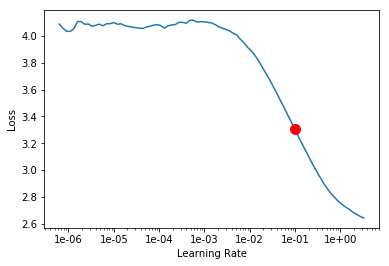

In [50]:
ulm_model.recorder.plot(suggestion=True)

In [0]:
preds, targets = ulm_model.get_preds()

In [0]:
predictions = np.argmax(preds, axis = 1)

In [53]:
ulm_model.predict('Военнослужащие–женщины на ')

'Военнослужащие–женщины на  2'

### Выводы

Для того, чтобы сравнить методы, построю столбчатую диаграмму

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

In [71]:
methods = list()
accuracy = list ()

methods.append('Классификация по правилам')
methods.append('Baseline')
methods.append('Снижение размерности')
methods.append('Лемматизация')
methods.append('Continious bag of words')
methods.append('fastText')
methods.append('CNN')
methods.append('RNN')
methods.append('ULMFit')

accuracy.append(0.8317432784041631)#
accuracy.append(0.9679098005203816)
accuracy.append(0.9622723330442324)
accuracy.append(0.9731136166522116)
accuracy.append(0.8330442324371206)#
accuracy.append(0.95836947094536)
accuracy.append(0.9700780572419775)
accuracy.append(0.9648742411101474)
accuracy.append(0.493750)

Text(0.5, 1.0, 'Столбчатая диаграмма значений accuracy для используемых методов')

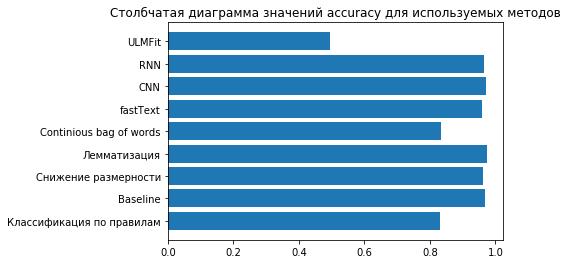

In [73]:
plt.barh(methods, accuracy)
plt.title('Столбчатая диаграмма значений accuracy для используемых методов')

### Выводы

По приведенной выше диаграмме сравнения accuracy для всех методов видно, что лучше всего с данной задачей справилась лемматизация с pipeline, в котором была использована логистическая регрессия. От лемматизации чуть отстает CNN. Также хорошо справились с задачей Baseline и Baseline со снижением размерности, RNN и FastText. Значительно отстают методы классификации по правилам и word2vec. Хуже всех с задачей справился метод ULMFit. 